## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp():
    """Code Here
    建立你的神經網路
    """
    return model

def build_mlp_bn(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_regularizer(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp_dropout(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [13]:
results = {}
train_loss='train_loss'
valid_loss='valid_loss'
train_acc='train_acc'
valid_acc='valid_acc'
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for reg in ["dropout","regularizer","batchnorm"]:
    if reg == "dropout":        
        model = build_mlp_dropout(input_shape=x_train.shape[1:])
    if reg == "regularizer":
        model = build_mlp_regularizer(input_shape=x_train.shape[1:])
    else:
        model = build_mlp_bn(input_shape=x_train.shape[1:])       
        
        
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    results[reg] = {}
    results[reg][train_loss] = model.history.history["loss"]
    results[reg][valid_loss] = model.history.history["val_loss"]
    results[reg][train_acc] = model.history.history["acc"]
    results[reg][valid_acc] = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 4s 74us/step - loss: 0.5227 - acc: 0.8515 - val_loss: 1.6624 - val_acc: 0.4858
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
____________________________________________________________

50000/50000 [==============================] - 3s 69us/step - loss: 1.4889 - acc: 0.5290 - val_loss: 1.5605 - val_acc: 0.4980
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________

50000/50000 [==============================] - 4s 76us/step - loss: 0.5196 - acc: 0.8510 - val_loss: 1.6612 - val_acc: 0.4959
Epoch 50/50
50000/50000 [==============================] - 4s 77us/step - loss: 0.5014 - acc: 0.8573 - val_loss: 1.6751 - val_acc: 0.4918


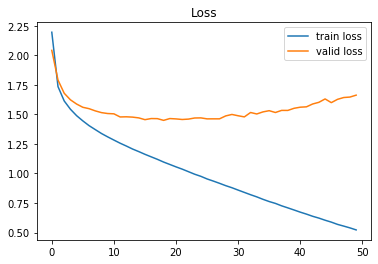

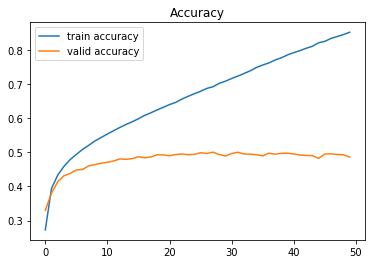

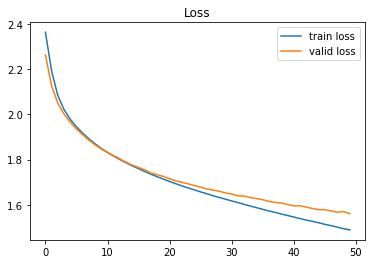

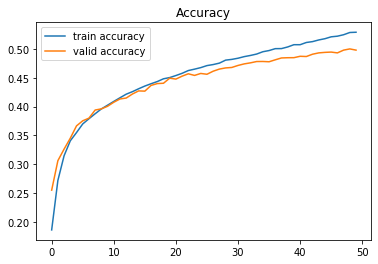

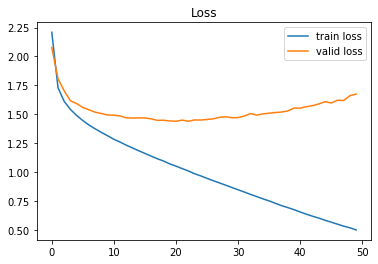

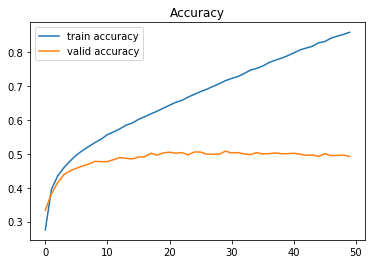

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

for reg in ["dropout","regularizer","batchnorm"]:
    train_loss_data=results[reg][train_loss]
    valid_loss_data=results[reg][valid_loss]
    plt.plot(range(len(train_loss_data)), train_loss_data, label="train loss")
    plt.plot(range(len(valid_loss_data)), valid_loss_data, label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    train_acc_data=results[reg][train_acc]
    valid_acc_data=results[reg][valid_acc]
    plt.plot(range(len(train_acc_data)), train_acc_data, label="train accuracy")
    plt.plot(range(len(valid_acc_data)), valid_acc_data, label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()